In [1]:
# TODO: Identify/remove outlier in input data. 
# TODO: Evaluate different feature sets.
# TODO: Randomly remove features
# TODO: error handling of input data types
# TODO: Ensure more broad testing of input data types (Nan/Zero handling)
# TODO: Improve plotting/metric evaluation
# TODO: Robust deployment on different machine

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.general_utils import (print_metrics)
from utils.pandas_utils import train_validate_test_split
from core.housing_prices_lib import (
    PrepareHousingData, StreetVectorizer, featurize_df
)
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score)
from sklearn.preprocessing import (Imputer)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# from xgboost import XGBRegressor
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='once')
# from sklearn.ensemble import LGBMRegressor

In [4]:
df = pd.read_csv('data/single_family_home_values.csv')

print('Preparing Data: cleaning data')
not_useful_fields = ['id','city','state']
date_fields = ['lastSaleDate', 'priorSaleDate']
required_fields = ['address','latitude','longitude','zipcode','bedrooms',
                   'bathrooms','rooms','squareFootage',
                   'lotSize','yearBuilt', 'lastSaleAmount',
                   'lastSaleDate', 'priorSaleDate','priorSaleAmount', 
                   'squareFootageOverLotSize','bathroomsPerRooms','hasPriorSale',
                   'bathroomsPerRooms','roomsPerSquareFootage']

features = ('latitude', 'longitude', 'zipcode',
            'bedrooms', 'bathrooms','rooms', 
            'squareFootage', 'lotSize', 
            'yearBuilt',
            'lastSaleAmount','lastSaleDateYear',
            'lastSaleDateDayOfWeek', 'lastSaleDateWeekOfYear',
           'priorSaleAmount','priorSaleDateYear',
            'priorSaleDateDayOfWeek', 'priorSaleDateWeekOfYear',
            'squareFootageOverLotSize','bathroomsPerRooms',
            'hasPriorSale', 'roomsPerSquareFootage')

zero_to_nan_fields = None
nan_to_zero_fields = ['latitude','longitude','priorSaleDate','priorSaleAmount', 'yearBuilt']

## ADD FEATURES
print('Adding self scaling features')
df['squareFootageOverLotSize'] = df['squareFootage']/df['lotSize']
df['bathroomsPerRooms'] = df['bathrooms']/(df['rooms']+.01)
df['roomsPerSquareFootage'] = df['rooms']/(df['squareFootage'])
df['hasPriorSale'] = ~pd.isnull(df['priorSaleDate'])



print('Preparing Data: splitting test/train/validation')
df_train, df_test, df_validation = train_validate_test_split(df)

y_test = df_test['estimated_value']
df_test = df_test[df_test.columns.drop('estimated_value')]

y_train = df_train['estimated_value'] 
df_train = df_train[df_train.columns.drop('estimated_value')]

# Scaling for other methods
# y_train_sc = np.log(y_train+1)
# y_train_mu = np.mean(y_train_sc)
# y_train_std = np.std(y_train_sc)
# Y_train_sc = (y_train_sc-y_train_mu)/y_train_std

# y_test_sc = np.log(y_test+1)
# y_test_mu = np.mean(y_test_sc)
# y_test_std = np.std(y_test_sc)
# y_test_sc = (y_test_sc-y_train_mu)/y_test_std

y_train_sc = y_train
y_test_sc = y_test

Preparing Data: cleaning data
Adding self scaling features
Preparing Data: splitting test/train/validation


In [5]:
from sklearn.ensemble import (
    ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor 
)
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
print("Setting up pipeline")



#: Note imputer will strip away column heads, it has to be after featurize
#reg_function = LGBMRegressor()
#reg_function = XGBRegressor()
# reg_function = RandomForestRegressor(n_jobs=3, criterion='mae') # about the same, slower by orders of magnitude
reg_function = RandomForestRegressor(n_jobs=3, criterion='mse')
# reg_function = LinearRegression() # Really Really bad
#reg_function = GradientBoostingRegressor()
#reg_function = AdaBoostRegressor(); #Really bad


prepare_data_pipeline = Pipeline([

        ('prepare_data', PrepareHousingData(required_fields=required_fields,
                                         date_fields=date_fields,
                                        zero_to_nan_fields=zero_to_nan_fields,
                                        nan_to_zero_fields=nan_to_zero_fields)), 
            ('union', FeatureUnion(
                transformer_list=[
                    # Extracting street vector
#                    ('subject',  StreetVectorizer()),
#                     ('imputerize_df', imputerize_df(features, df_out=True)),
                    # Featurizing all other values
                    ('featurize_df', featurize_df(features, df_out=False)),
                ]
             )),
                      ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
            ])

fit_data_pipeline = Pipeline([
          ('forest', reg_function),
            
            ])

Setting up pipeline
Featurize


/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils import arrayfuncs, as_float_array, check_X_y
/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:24: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ..utils import arrayf

In [6]:
# # from keras.layers import Dense, Dropout
# from keras.models import Model, Sequential
# from keras.wrappers.scikit_learn import KerasRegressor
# def create_model(optimizer='adagrad',
#                  kernel_initializer='glorot_uniform', 
#                  dropout=0.2):
#     model = Sequential()
#     model.add(Dense(64,activation='relu',kernel_initializer=kernel_initializer))
#     model.add(Dropout(dropout))
#     model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

#     model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=['accuracy'])

#     return model

# # wrap the model using the function you created
# clf = KerasRegressor(build_fn=create_model,verbose=0)
# scaler = StandardScaler()

# fit_data_pipeline = Pipeline([
# #     ('preprocess',scaler),
#           ('keras', clf)
#             ])

In [7]:
print("Preparing training data")
x_train = prepare_data_pipeline.fit_transform(X = df_train, y = y_train_sc.values.reshape((-1,1)))
print("Fitting model on training data")
model = fit_data_pipeline.fit(X = x_train, y = y_train_sc.values.reshape((-1,1)))

Preparing training data


/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/sklearn/pipeline.py:270: DataConversionWarning: A column-vector y was passed whe

Fitting model on training data


Evaluating model on training data
Sqrt mse: 62371.6391927
Mean absolute error: 24375.7189833
R2 score: 0.985217976997
Absolute mean relative error: 0.0328316869584


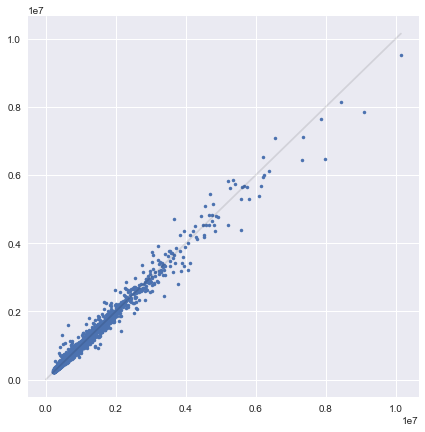

Evaluating model on testing data
Sqrt mse: 154908.408739
Mean absolute error: 65315.9266667
R2 score: 0.901194611813
Absolute mean relative error: 0.0849426861392


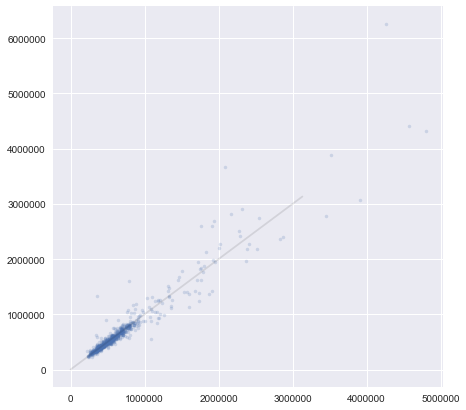

Successfully fit


In [48]:
print("Evaluating model on training data")
y_pred = model.predict(x_train)
# y_pred = model.named_steps['forest'].predict(x_train)
print_metrics(y_train_sc.values, y_pred)
plt.figure(figsize=(7,7))
plt.plot(y_train_sc.values, y_pred,'.')
y_max = (np.max((y_train_sc.values, y_pred.flatten())))
plt.plot((0,y_max), (0,y_max),color='black', alpha=0.1)
plt.show()

print("Evaluating model on testing data")

x_test = prepare_data_pipeline.transform(df_test)
y_test_pred = fit_data_pipeline.predict(x_test)
# y_test_pred = model.named_steps['forest'].predict(X_test)
print_metrics(y_test_sc.values, y_test_pred)
plt.figure(figsize=(7,7))
plt.plot(y_test_sc.values, y_test_pred.flatten(),'.', alpha=0.2)
# y_max = np.max((y_test_sc, y_test_pred.flatten()))*0.5
y_max = 1e6
plt.plot((0,y_max), (0,y_max),color='black', alpha=0.1)

plt.show()
print("Successfully fit")

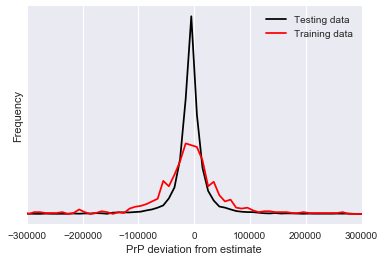

In [34]:
[c,b] = np.histogram(y_train_sc.values- y_pred.flatten(), bins = np.linspace(-1e6,1e6,200), normed=True)
plt.plot(b[:-1],c,'k')
[c,b] = np.histogram(y_test_sc.values- y_test_pred.flatten(), bins = np.linspace(-1e6,1e6,200), normed=True)
# plt.subplots(figsize=(5,5))
plt.plot(b[:-1],c,'r')
plt.xlim((-3e5, 3e5))
plt.legend(('Testing data','Training data'))
plt.xlabel('PrP deviation from estimate')
plt.ylabel('Frequency')
frame1 = plt.gca()
# frame1.axes.get_yaxis().set_visible(False)
frame1.axes.get_yaxis().set_ticks([])

plt.show()



In [10]:
from sklearn.externals import joblib
import os
model_dir = 'models'
filename = os.path.join(model_dir, 'finalized_prepare_data_pipeline.sav')
print('Saving data preparation model to {}'.format(filename))
joblib.dump(prepare_data_pipeline, filename)
filename = os.path.join('finalized_fit_data_pipeline.sav')
print('Saving data fitting model to {}'.format(filename))
joblib.dump(fit_data_pipeline, filename)
  
# some time later...
# load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)

Saving data preparation model to models/finalized_prepare_data_pipeline.sav
Saving data fitting model to finalized_fit_data_pipeline.sav


['finalized_fit_data_pipeline.sav']

/Users/ian/miniconda2/envs/hprice/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


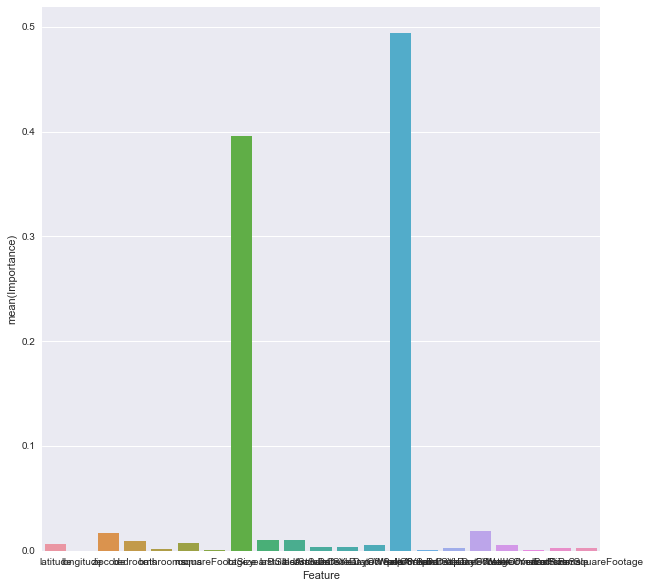

In [11]:
fp =  fit_data_pipeline.steps[0][1].feature_importances_
data_imp = pd.DataFrame({'Feature': features, 'Importance': fp})
plt.figure(figsize=(10,10))
sns.barplot(x='Feature',y='Importance',data=data_imp)
plt.show()
# (fit_data_pipeline.steps[0][1].feature_importances_)

In [12]:
 fit_data_pipeline.steps[0][1].feature_importances_.shape

(21,)

In [13]:
data_imp.sort_values('Importance', ascending=False)

,Feature,Importance
13,priorSaleAmount,0.493956
7,lotSize,0.395786
16,priorSaleDateWeekOfYear,0.019041
2,zipcode,0.016603
9,lastSaleAmount,0.010660
8,yearBuilt,0.009917
3,bedrooms,0.008927
5,rooms,0.007732
0,latitude,0.006958
17,squareFootageOverLotSize,0.005643


In [14]:
df_train.loc[df_train['latitude']==0, 'latitude'] = np.nan
df_train.loc[df_train['longitude']==0, 'longitude'] = np.nan

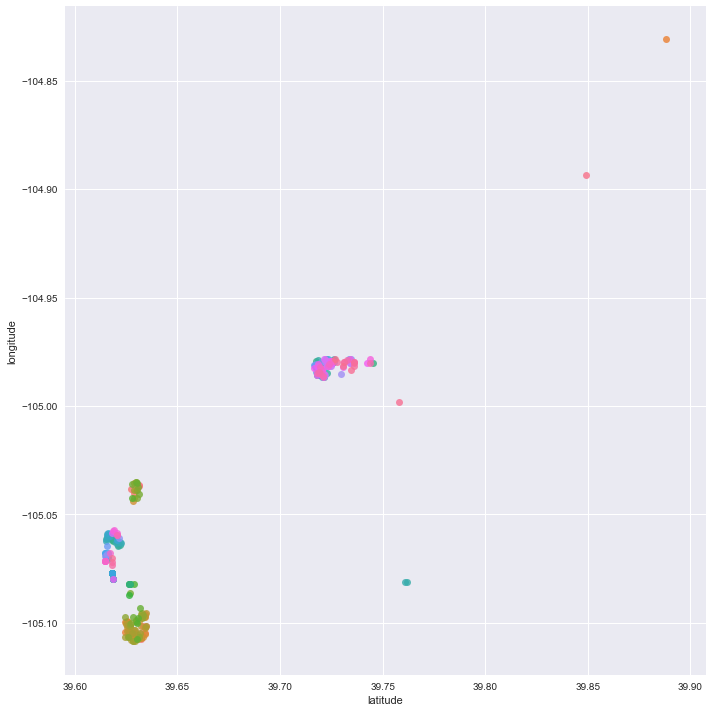

In [15]:
# fig = plt.figure()
# fig, ax = plt.subplots(figsize=(20,20))
# plt.figure(figsize=(20,20))
sns.lmplot(x='latitude',y='longitude', data=df[:300], fit_reg=False, hue='estimated_value', legend=False,size=10)

# plt.plot(df_train['latitude'].dropna().values, df_train['longitude'].dropna().values, '.')
plt.show()

In [16]:
#: Work on using grid-searches
# params = {'forest__n_estimators':  (39,42)}
params = {'forest__n_estimators':  np.arange(5,45,5)}
# params = {'forest__n_estimators':  np.arange(35,45,5),
#           'forest__max_features':  ['auto','sqrt']}

from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p)
# transformer.transform(y)
grid = GridSearchCV(fit_data_pipeline, params)

grid.fit(X = x_train, y = y_train)

#: Definining a specified cross-validation technique
cv= StratifiedKFold(n_splits=2)

# Alternatively, can say can say cv=3 to say a 3-repeat cross-validator
grid_search = GridSearchCV(fit_data_pipeline, params, cv=5)
#gsearch = GridSearchCV(pipeline, params)
grid_search.fit(X = x_train, y = y_train)
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=35, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

[ 0.97854002  0.98391982  0.98469778  0.98624575  0.98656167  0.98802668
  0.98764121  0.98796922]


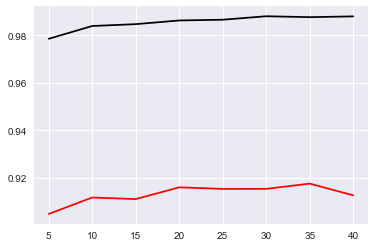

In [17]:
print(grid_search.cv_results_['mean_train_score'])
plt.plot(params['forest__n_estimators'], grid_search.cv_results_['mean_train_score'],'k')
plt.plot(params['forest__n_estimators'], grid_search.cv_results_['mean_test_score'],'r')
plt.show()

In [18]:
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=35, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [23]:
fp = best_pipeline.get_params()['forest'].feature_importances_
# fp =  fit_data_pipeline.steps[0][1].feature_importances_
# data_imp = pd.DataFrame({'Feature': features, 'Importance': fp})
# plt.figure(figsize=(10,10))
# sns.barplot(x='Feature',y='Importance',data=data_imp)
# plt.show()
# (fit_data_pipeline.steps[0][1].feature_importances_)
data_imp.sort_values('Importance', ascending=False)

,Feature,Importance
13,priorSaleAmount,0.493956
7,lotSize,0.395786
16,priorSaleDateWeekOfYear,0.019041
2,zipcode,0.016603
9,lastSaleAmount,0.010660
8,yearBuilt,0.009917
3,bedrooms,0.008927
5,rooms,0.007732
0,latitude,0.006958
17,squareFootageOverLotSize,0.005643


In [45]:
grid_search.

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'forest__n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [ ]:
X = X_test
y = y_test
y_pred = best_pipeline.predict(X)
print_metrics(y, y_pred)
plt.plobt(y, y_pred,'.',alpha=0.7)
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black',alpha=0.2)
plt.axes().set_aspect('equal')
b
plt.show()

(0, 4000000.0)

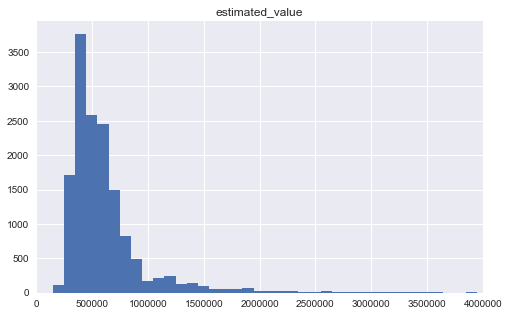

In [43]:
# fig, ax = plt.figure(figsize=(7,4))
df.hist(column='estimated_value', grid=True,ylabelsize=None,  ax=None, figsize=(8,5), layout=None, bins=100)
plt.xlim((0, 4e6))

Evaluating model on training data
Sqrt mse: 62371.6391927
Mean absolute error: 24375.7189833
R2 score: 0.985217976997
Absolute mean relative error: 0.0328316869584


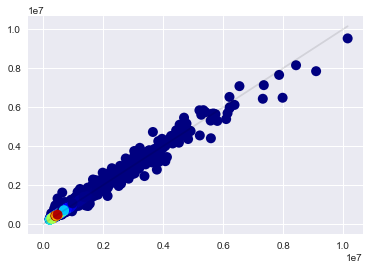

Evaluating model on testing data
Sqrt mse: 154908.408739
Mean absolute error: 65315.9266667
R2 score: 0.901194611813
Absolute mean relative error: 0.0849426861392


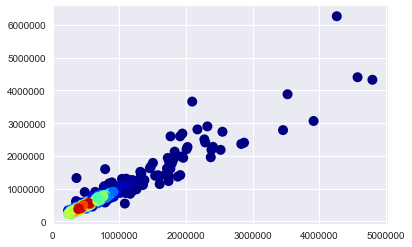

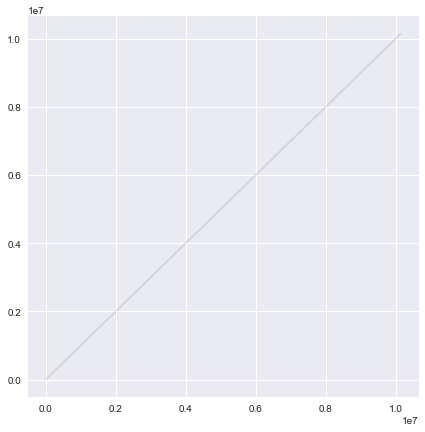

Successfully fit


In [60]:
from scipy.stats import gaussian_kde
y_max = 1e6

print("Evaluating model on training data")
y_pred = model.predict(x_train)
print_metrics(y_train_sc.values, y_pred)

xy = np.vstack([y_train_sc.values,y_pred])
z = gaussian_kde(xy)(xy)
plt.figure(figsize=(7,7))

fig, ax = plt.subplots()
ax.scatter(y_train_sc.values,y_pred, c=z, s=100, edgecolor='',cmap='jet')

y_max = (np.max((y_train_sc.values, y_pred.flatten())))
plt.plot((0,y_max), (0,y_max),color='black', alpha=0.1)
plt.show()

print("Evaluating model on testing data")

x_test = prepare_data_pipeline.transform(df_test)
y_test_pred = fit_data_pipeline.predict(x_test)
print_metrics(y_test_sc.values, y_test_pred)

xy = np.vstack([y_test_sc.values, y_test_pred.flatten()])
z2 = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()

plt.figure(figsize=(7,7))
ax.scatter(y_test_sc.values, y_test_pred.flatten(), c=z2, s=100, edgecolor='',cmap='jet')


plt.plot((0,y_max), (0,y_max),color='black', alpha=0.1)

plt.show()
print("Successfully fit")

In [52]:
ax.scatter?

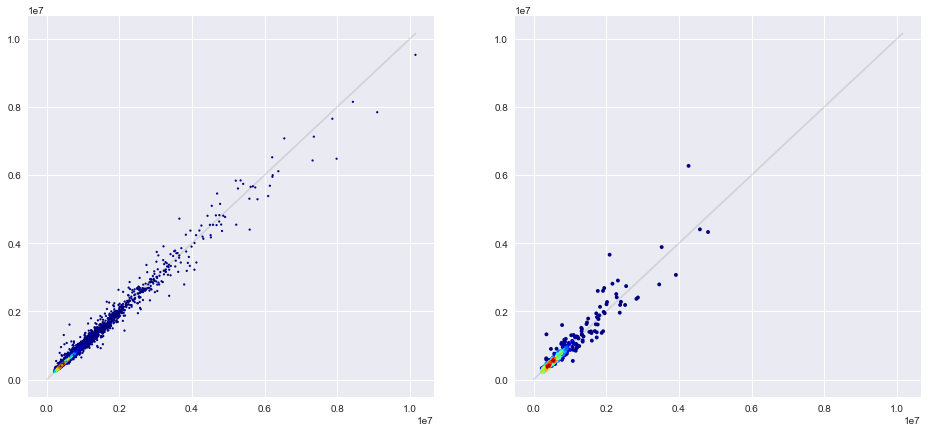

In [67]:
y_max=1e6
fig, ax = plt.subplots(1,2,figsize=(16,7))
ax[0].scatter(y_train_sc.values,y_pred, c=z, s=5, edgecolor='',cmap='jet')
ax[0].plot((0,y_max), (0,y_max),color='black', alpha=0.1)
ax[0].xlim=((0,y_max))
ax[0].ylim=((0,y_max))
ax[1].scatter(y_test_sc.values, y_test_pred.flatten(), c=z2, s=15, edgecolor='',cmap='jet')
ax[1].plot((0,y_max), (0,y_max),color='black', alpha=0.1)
ax[1].xlim=((0,y_max))
ax[1].ylim=((0,y_max))

In [58]:
np.any(np.isnan(y_test_pred.flatten()))

False

TypeError: 'tuple' object is not callable

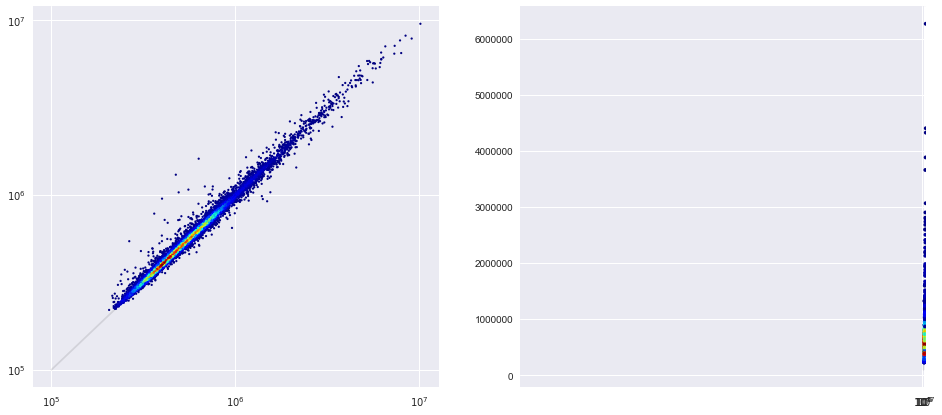

In [99]:
xy = np.vstack(np.log([y_train_sc.values,y_pred]))
z = gaussian_kde(xy)(xy)
plt.figure(figsize=(7,7))

xy = np.vstack(np.log([y_test_sc.values, y_test_pred.flatten()]))
z2 = gaussian_kde(xy)(xy)




y_max = (1e6)
y_min = 1e5
fig, ax = plt.subplots(1,2,figsize=(16,7))
ax[0].scatter((y_train_sc.values),(y_pred), c=z, s=5, edgecolor='',cmap='jet')
ax[0].plot((y_min,y_max), (y_min,y_max),color='black', alpha=0.1)
ax[0].xlim=((y_min,y_max))
ax[0].ylim=((y_min,y_max))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].title('Pricing Prediciton on Training Data')
ax[1].scatter((y_test_sc.values), (y_test_pred.flatten()), c=z2, s=15, edgecolor='',cmap='jet')
ax[1].plot((y_min,y_max), (y_min,y_max),color='black', alpha=0.1)
ax[1].set_xlim=((y_min,y_max))
ax[1].set_ylim=((y_min,y_max))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel['estimated_prices']
ax[0].set_ylabel['pricing prediction']
# ax[1].title('Pricing Prediciton on Test Data')

In [71]:
fig.

array([[ 12.80227932,  14.2882386 ,  13.45887847, ...,  12.85045491,
         12.87907834,  13.40974891],
       [ 12.85969803,  13.94690875,  13.36536744, ...,  12.83699702,
         12.87421684,  13.50710319]])

In [72]:
np.log(1e6)

13.815510557964274

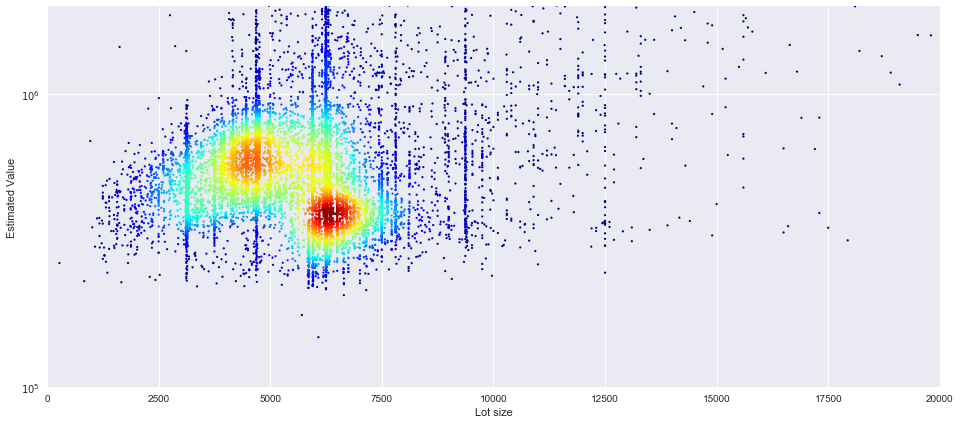

In [120]:
# df = pd.read_csv('data/single_family_home_values.csv')
# x = df['lotSize']
# y = df['estimated_value']
# xy = np.vstack(([x,np.log(y)]))
# z = gaussian_kde(xy)(xy)

y_max = (2e6)
y_min = 1e5
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.scatter(x,y, c=z, s=5, edgecolor='',cmap='jet')
ax.set_xlim(0, 20000)
ax.set_ylim(y_min,y_max)
# ax[0].set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lot size')
ax.set_ylabel('Estimated Value')

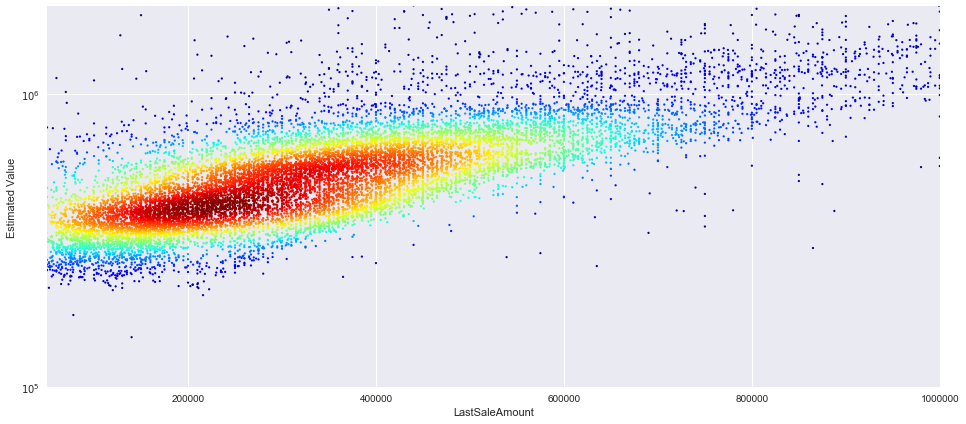

In [122]:
df = pd.read_csv('data/single_family_home_values.csv')
df.loc[pd.isnull(df['lastSaleAmount']), 'lastSaleAmount']=0
x = df['lastSaleAmount']
y = df['estimated_value']
xy = np.vstack(([x,np.log(y)]))
z = gaussian_kde(xy)(xy)

y_max = (2e6)
y_min = 1e5
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.scatter(x,y, c=z, s=5, edgecolor='',cmap='jet')
ax.set_xlim(5e4, 1e6)
ax.set_ylim(y_min,y_max)
# ax[0].set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('LastSaleAmount')
ax.set_ylabel('Estimated Value')

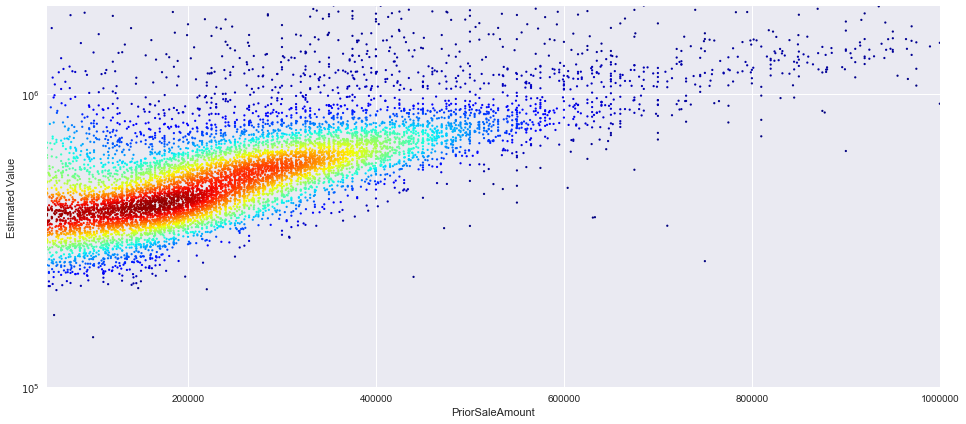

In [121]:
df = pd.read_csv('data/single_family_home_values.csv')
df.loc[pd.isnull(df['priorSaleAmount']), 'priorSaleAmount']=0
x = df['priorSaleAmount']
y = df['estimated_value']
xy = np.vstack(([x,np.log(y)]))
z = gaussian_kde(xy)(xy)

y_max = (2e6)
y_min = 1e5
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.scatter(x,y, c=z, s=5, edgecolor='',cmap='jet')
ax.set_xlim(5e4, 1e6)
ax.set_ylim(y_min,y_max)
# ax[0].set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('PriorSaleAmount')
ax.set_ylabel('Estimated Value')

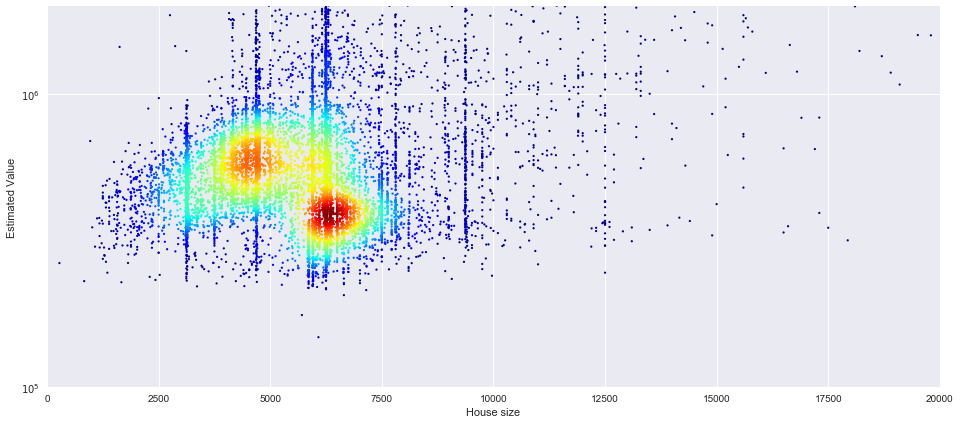

In [119]:
df = pd.read_csv('data/single_family_home_values.csv')
df.loc[pd.isnull(df['lastSaleAmount']), 'lastSaleAmount']=0

x = df['lotSize']
y = df['estimated_value']
xy = np.vstack(([x,np.log(y)]))
z = gaussian_kde(xy)(xy)

y_max = (2e6)
y_min = 1e5
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.scatter(x,y, c=z, s=5, edgecolor='',cmap='jet')
ax.set_xlim(0, 20000)
ax.set_ylim(y_min,y_max)
# ax[0].set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('House size')
ax.set_ylabel('Estimated Value')

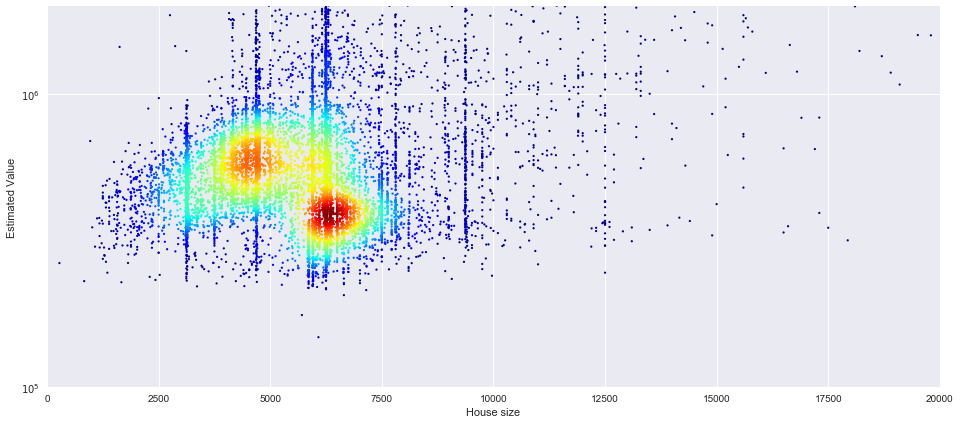

In [123]:
df = pd.read_csv('data/single_family_home_values.csv')
df.loc[pd.isnull(df['priorSaleAmount']), 'priorSaleAmount']=0

x = df['lotSize']
y = df['estimated_value']
xy = np.vstack(([x,np.log(y)]))
z = gaussian_kde(xy)(xy)

y_max = (2e6)
y_min = 1e5
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.scatter(x,y, c=z, s=5, edgecolor='',cmap='jet')
ax.set_xlim(0, 20000)
ax.set_ylim(y_min,y_max)
# ax[0].set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lot size')
ax.set_ylabel('Estimated Value')

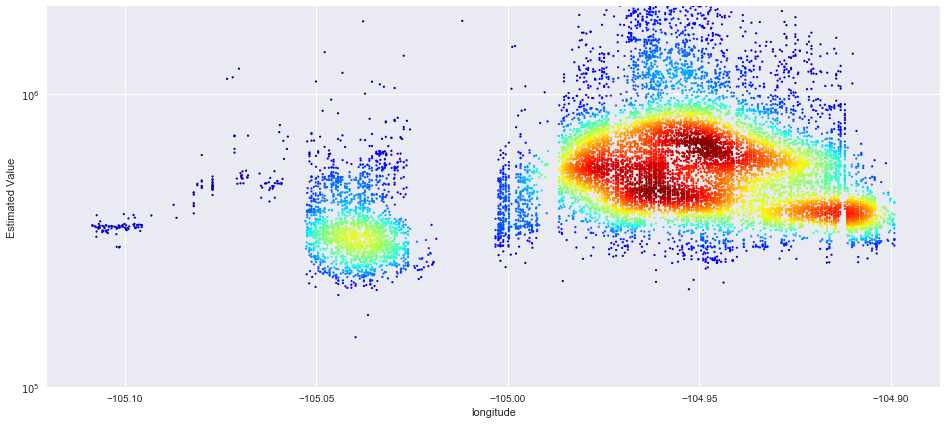

In [153]:
df = pd.read_csv('data/single_family_home_values.csv')
# df.drop(pd.isnull(df['priorSaleAmount']), 'priorSaleAmount')
    
df.drop(pd.isnull(df['longitude']), inplace=True)

x = df['longitude']
y = df['estimated_value']
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]
xy = np.vstack(([x,np.log(y)]))
z = gaussian_kde(xy)(xy)

y_max = (2e6)
y_min = 1e5
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.scatter(x,y, c=z, s=5, edgecolor='',cmap='jet')
# ax.set_xlim(0, 20000)
ax.set_ylim(y_min,y_max)
# ax[0].set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('longitude')
ax.set_ylabel('Estimated Value')

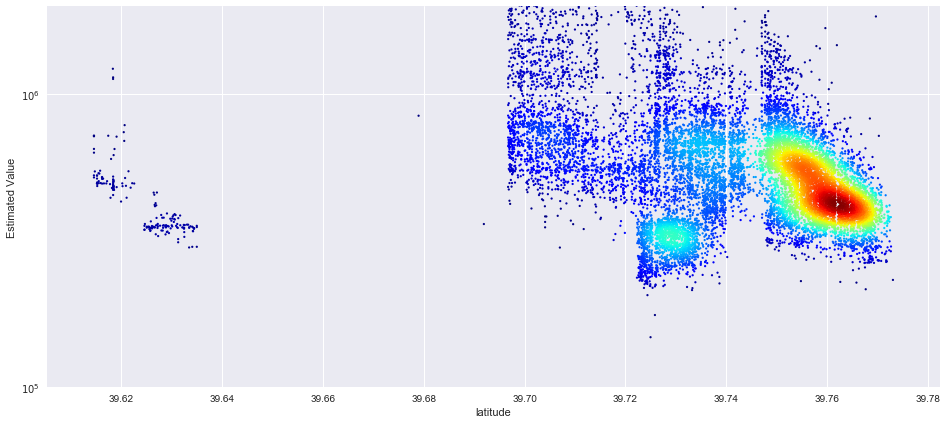

In [155]:
df = pd.read_csv('data/single_family_home_values.csv')
# df.drop(pd.isnull(df['priorSaleAmount']), 'priorSaleAmount')
    
df.drop(pd.isnull(df['latitude']), inplace=True)

x = df['latitude']
y = df['estimated_value']
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]
xy = np.vstack(([x,np.log(y)]))
z = gaussian_kde(xy)(xy)

y_max = (2e6)
y_min = 1e5
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.scatter(x,y, c=z, s=5, edgecolor='',cmap='jet')
# ax.set_xlim(0, 20000)
ax.set_ylim(y_min,y_max)
# ax[0].set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('latitude')
ax.set_ylabel('Estimated Value')

In [152]:
y.shape

(14998,)

In [5]:
df = pd.read_csv('data/single_family_home_values.csv')
df.drop(labels='estimated_value', axis=1, inplace=True)
df.to_csv('data/stripped_home_values.csv')